<a href="https://colab.research.google.com/github/IlyessAgg/mLproject/blob/main/Build_a_Generative_Adversarial_Network_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning with PyTorch : Build a Generative Adversarial Network

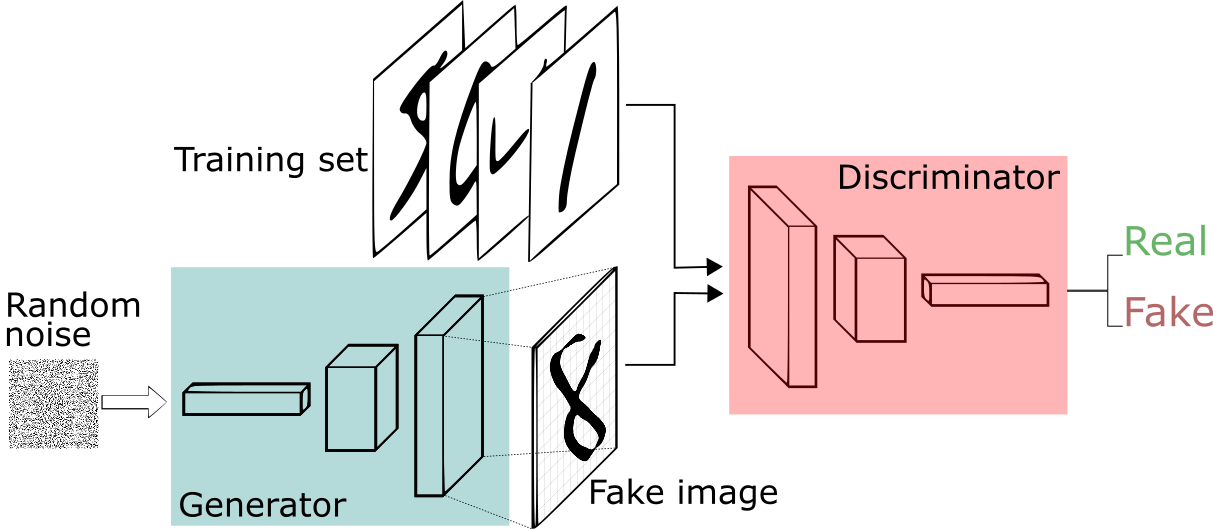

In [ ]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [ ]:
DEVICE = 'cuda'

BATCH_SIZE = 128
NOISE_DIM = 64
EPOCHS = 20
LR = 0.002
BETA_1 = 0.5
BETA_2 = 0.99

# Load MNIST Dataset

In [ ]:
from torchvision import datasets, transforms as T

In [ ]:
train_augs = T.Compose([
    T.RandomRotation((-20, +20)),
    T.ToTensor() # (h, w, c) -> (c, h, w)
])

In [ ]:
trainset = datasets.MNIST('MNIST/', download=True, train=True, transform=train_augs)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5173550.36it/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 149442.49it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1425850.86it/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5029178.66it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



In [ ]:
print('Total images in trainset : ', len(trainset))

Total images in trainset :  60000


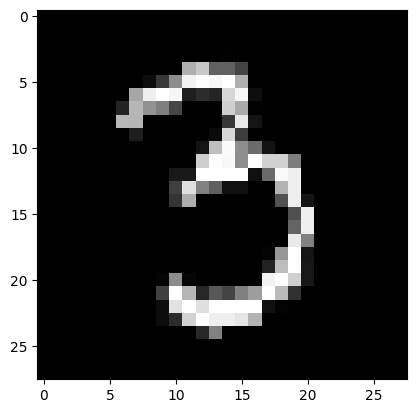

In [ ]:
image, label = trainset[50]

plt.imshow(image.squeeze(), cmap='gray')

# Load Dataset Into Batches

In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)

In [ ]:
print('Total number of batches of trainloader', len(trainloader))

Total number of batches of trainloader 469


In [ ]:
for images, labels in trainloader:
  break;

print(f"One batch image shape : {images.shape}")
print(f"One batch label shape : {labels.shape}")

One batch image shape : torch.Size([128, 1, 28, 28])
One batch label shape : torch.Size([128])


In [ ]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

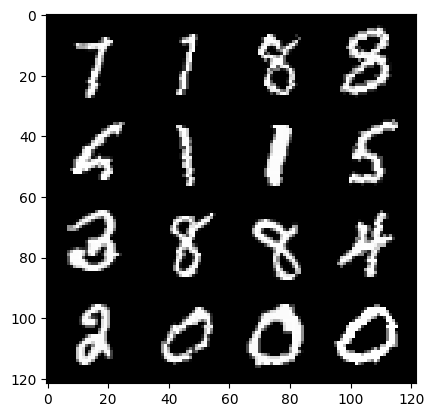

In [ ]:
show_tensor_images(images)

# Create Discriminator Network

In [ ]:
#In case if torch summary is not installed

!pip install torchsummary

In [ ]:
from torch import nn
from torchsummary import summary

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

In [ ]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [ ]:
class Discriminator(nn.Module):

  def __init__(self):
     super(Discriminator, self).__init__()

     self.block_1 = get_disc_block(1, 16, (3,3), 2)
     self.block_2 = get_disc_block(16, 32, (5,5), 2)
     self.block_3 = get_disc_block(32, 64, (5,5), 2)

     self.flatten = nn.Flatten()
     self.linear = nn.Linear(in_features=64, out_features=1)

  def forward(self, images):

    x = self.block_1(images)
    x = self.block_2(x)
    x = self.block_3(x)

    x = self.flatten(x)
    x = self.linear(x)

    return x

In [ ]:
D = Discriminator()
D.to(DEVICE)

summary(D, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [ ]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator\n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)\n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                                 

In [ ]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block = False):
  if final_block:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.Tanh()
    )

  return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
  )

In [ ]:
class Generator(nn.Module):

  def __init__(self):
     super(Generator, self).__init__()

     self.NOISE_DIM = NOISE_DIM
     self.block_1 = get_gen_block(NOISE_DIM, 256, (3,3), 2)
     self.block_2 = get_gen_block(256, 128, (4,4), 1)
     self.block_3 = get_gen_block(128, 64, (3,3), 2)

     self.block_4 = get_gen_block(64, 1, (4,4), 2, final_block=True)

  def forward(self, r_noise_vec):

    # (bs, noise_dim) -> (bs, noise_dim, 1, 1) ## (..., h, w)
    x = r_noise_vec.view(-1, self.NOISE_DIM, 1, 1)

    x = self.block_1(x)
    x = self.block_2(x)
    x = self.block_3(x)
    x = self.block_4(x)

    return x

In [ ]:
G = Generator()
G.to(DEVICE)

summary(G, input_size=(1,NOISE_DIM))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [ ]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [ ]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

In [ ]:
def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

In [ ]:
D_opt = torch.optim.Adam(D.parameters(), lr = LR, betas = (BETA_1, BETA_2))
G_opt = torch.optim.Adam(G.parameters(), lr = LR, betas = (BETA_1, BETA_2))

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH : 1 D LOSS : 0.6642795349997498 G LOSS : 0.7645384261348863


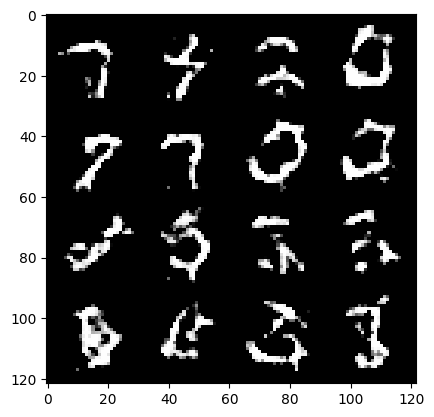

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH : 2 D LOSS : 0.6117690355538814 G LOSS : 0.8976301840627625


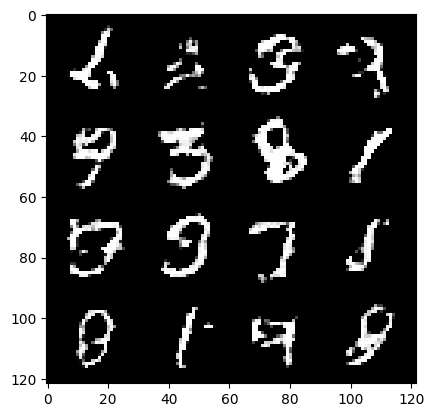

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH : 3 D LOSS : 0.5902253313105243 G LOSS : 0.9834939146092706


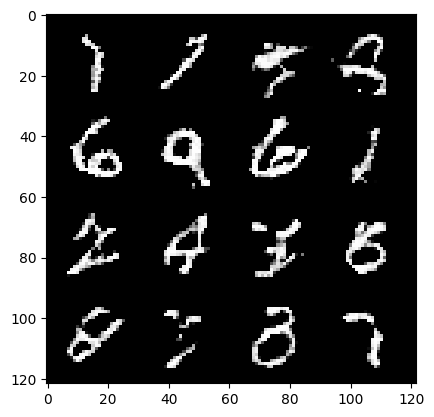

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH : 4 D LOSS : 0.5982634460748132 G LOSS : 0.9992492146837686


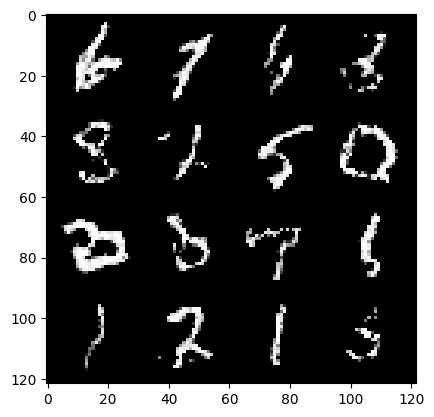

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH : 5 D LOSS : 0.6036658128187347 G LOSS : 0.9970297556696162


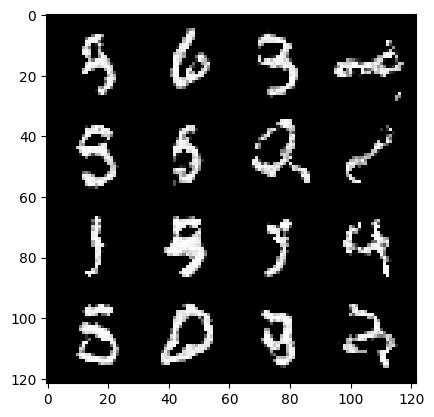

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH : 6 D LOSS : 0.6050046406575104 G LOSS : 1.000380996702068


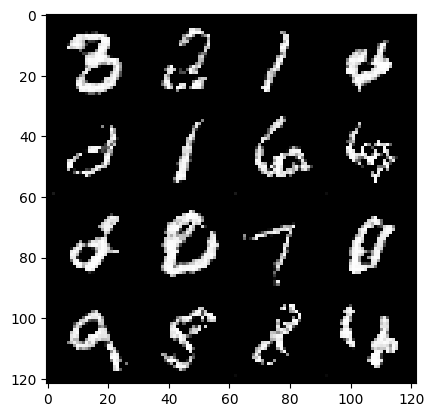

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH : 7 D LOSS : 0.6020595986705853 G LOSS : 1.004567245049263


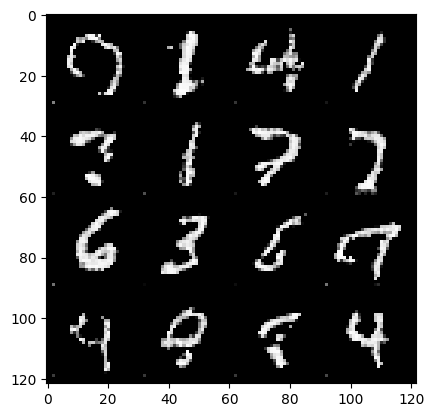

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH : 8 D LOSS : 0.5991938185335984 G LOSS : 1.0180334676303335


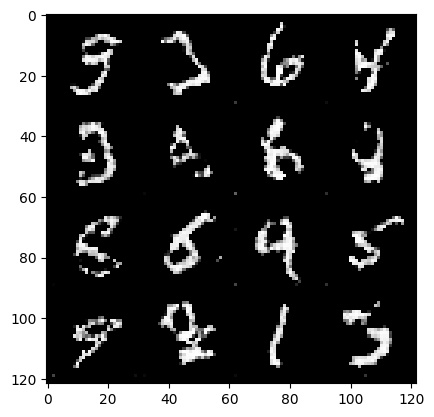

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH : 9 D LOSS : 0.5875400353088054 G LOSS : 1.0405672521733527


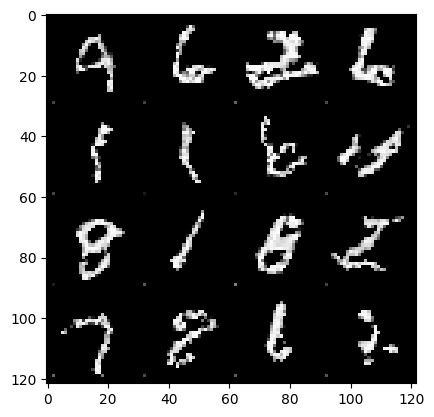

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH : 10 D LOSS : 0.5764326348996112 G LOSS : 1.0797830907774886


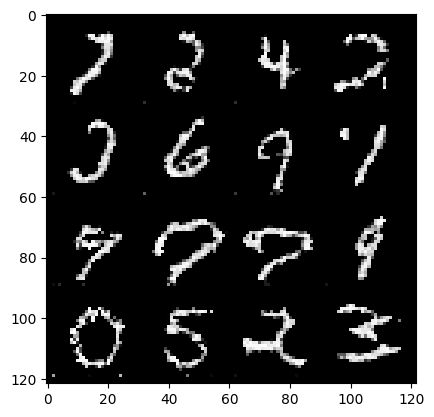

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH : 11 D LOSS : 0.5722385543241684 G LOSS : 1.0981530544600253


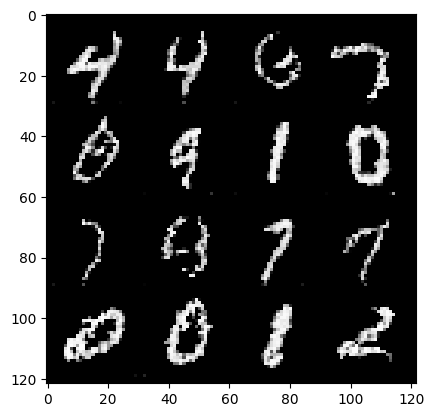

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH : 12 D LOSS : 0.5635823636039742 G LOSS : 1.1202927751581806


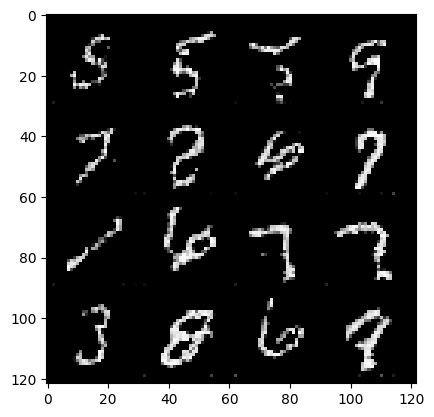

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH : 13 D LOSS : 0.5603028489455485 G LOSS : 1.1364226993213076


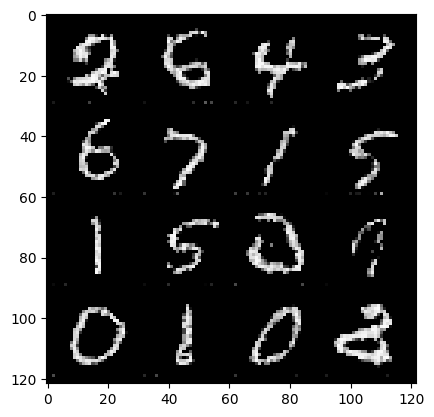

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH : 14 D LOSS : 0.5560755037676806 G LOSS : 1.1465949466996102


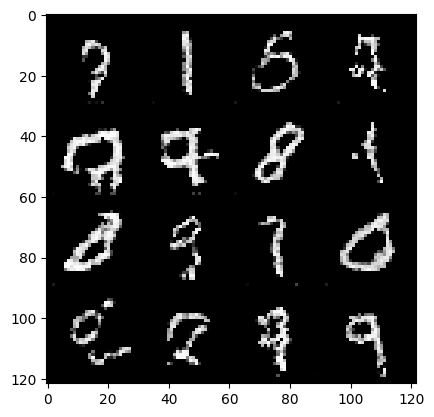

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH : 15 D LOSS : 0.5517901541835972 G LOSS : 1.1646257297062417


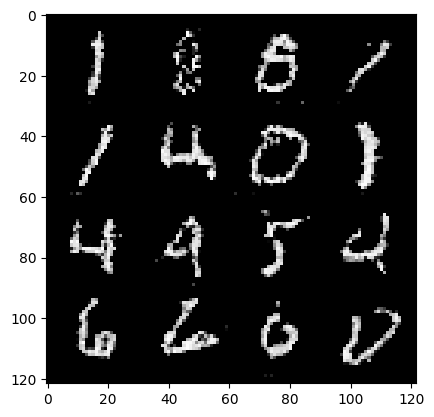

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH : 16 D LOSS : 0.550338462344619 G LOSS : 1.171712261400243


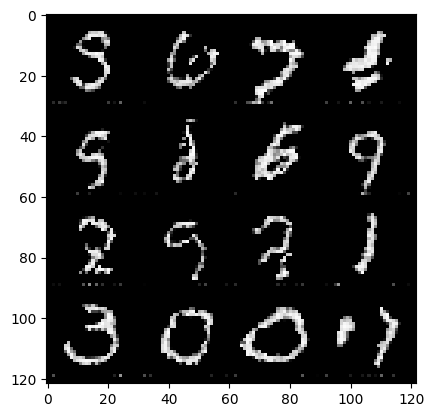

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH : 17 D LOSS : 0.550764735319467 G LOSS : 1.1724372834030754


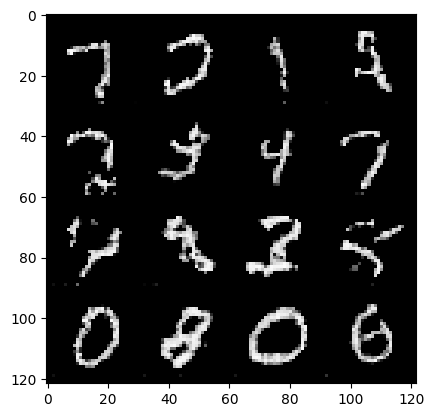

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH : 18 D LOSS : 0.5514648722560167 G LOSS : 1.173492544495475


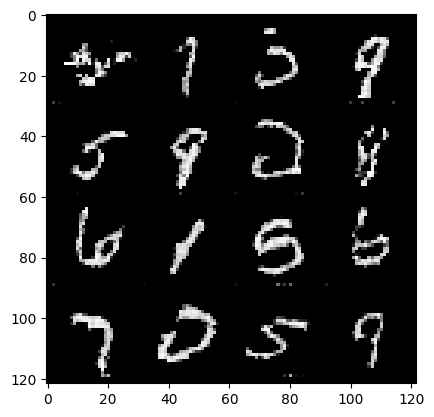

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH : 19 D LOSS : 0.552964234657125 G LOSS : 1.1668291107169602


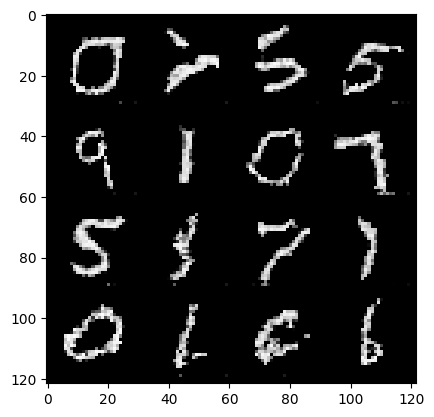

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH : 20 D LOSS : 0.5528412365328783 G LOSS : 1.166334928098772


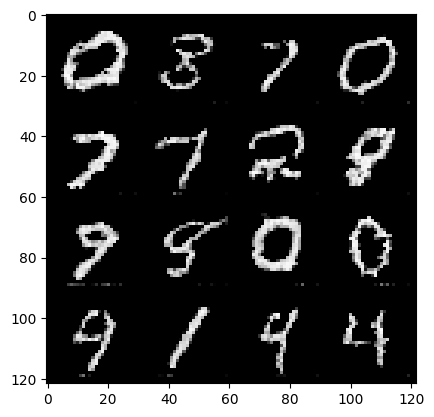

In [ ]:
for i in range(EPOCHS):

  total_d_loss = 0.0
  total_g_loss = 0.0

  for real_img, _ in tqdm(trainloader):

    real_img = real_img.to(DEVICE)
    noise = torch.randn(BATCH_SIZE, NOISE_DIM, device = DEVICE)

    # find loss and update weights for D

    D_opt.zero_grad()

    fake_img = G(noise)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_fake_loss + D_real_loss)/2

    total_d_loss += D_loss.item()

    D_loss.backward()
    D_opt.step()

    # find loss and update weights for G

    G_opt.zero_grad()

    noise = torch.randn(BATCH_SIZE, NOISE_DIM, device = DEVICE)
    fake_img = G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss(D_pred)

    total_g_loss += G_loss.item()

    G_loss.backward()
    G_opt.step()


  avg_d_loss = total_d_loss / len(trainloader)
  avg_g_loss = total_g_loss / len(trainloader)

  print(f"EPOCH : {i+1} D LOSS : {avg_d_loss} G LOSS : {avg_g_loss}")

  show_tensor_images(fake_img)

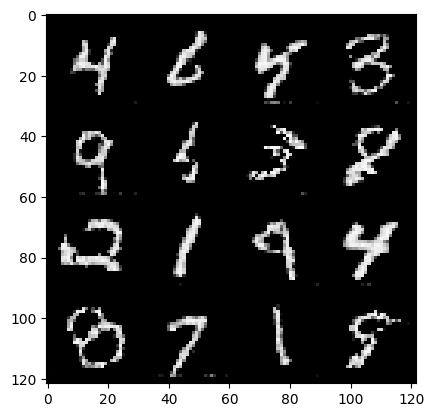

In [ ]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(BATCH_SIZE, NOISE_DIM, device = DEVICE)
generated_image = G(noise)

show_tensor_images(generated_image)